### to using gpu in kaggle

In [1]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Or with torch
import torch
print("CUDA Available: ", torch.cuda.is_available())
print("GPU Device Name: ", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

2025-05-15 20:26:01.317513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747340761.567376      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747340761.637856      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
CUDA Available:  True
GPU Device Name:  Tesla T4


# Library Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer

from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
import joblib
import os


# Data Loading 


1. Load the CIFAR-10 training data from 5 batches
2. Combine them into a single training set
3. Load the test batch separately
4. Load category names from metadata

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo: # rb is reading binary brcause the most data storing in pickl is binary
        data = pickle.load(fo, encoding='bytes')   # Contains keys or values in byte form
    return data

In [ ]:
x_list = [] # to save data of images 
y_list = [] # to save label of images like airplane,automobile,....


for i in range(1, 6):
    batch = unpickle(f'data/cifar-10-batches-py/data_batch_{i}')
    data = batch[b'data']  # Raw image data (10000, 3072)
    labels = batch[b'labels']  # Labels (length = 10000)
    
    # I made it -1 so that if he doesn't know how much data I have while he's writing it ,   but we knew the number of data so we can replace it with 10000   
    images = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)                                                             

    
    x_list.append(images)
    y_list.extend(labels)


print(batch.keys())

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [5]:
first_image = x_list[0][0]  # first image in batch
print(f"First image array (shape: {first_image.shape}):")
print(first_image)

First image array (shape: (32, 32, 3)):
[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


In [7]:
x_train = np.concatenate(x_list)
y_train = np.array(y_list)

print(f"Combined X_train shape: {x_train.shape}")
print(f"Combined y_train shape: {y_train.shape}")

Combined X_train shape: (50000, 32, 32, 3)
Combined y_train shape: (50000,)


In [8]:
test_batch = unpickle('data/cifar-10-batches-py/test_batch')
x_test = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
y_test = np.array(test_batch[b'labels'])

print(f"Combined X_train shape: {x_test.shape}")
print(f"Combined y_train shape: {y_test.shape}")

Combined X_train shape: (10000, 32, 32, 3)
Combined y_train shape: (10000,)


In [9]:
meta = unpickle('data/cifar-10-batches-py/batches.meta')

# This decodes each byte string and converts it to a regular string
label_names = []
for label in meta[b'label_names']:
    name = label.decode('utf-8')
    label_names.append(name)

print("Category names:", label_names)

Category names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Data Visualization

1. Random sample of 25 images from the training set
2. Class distribution visualization for both training and test sets

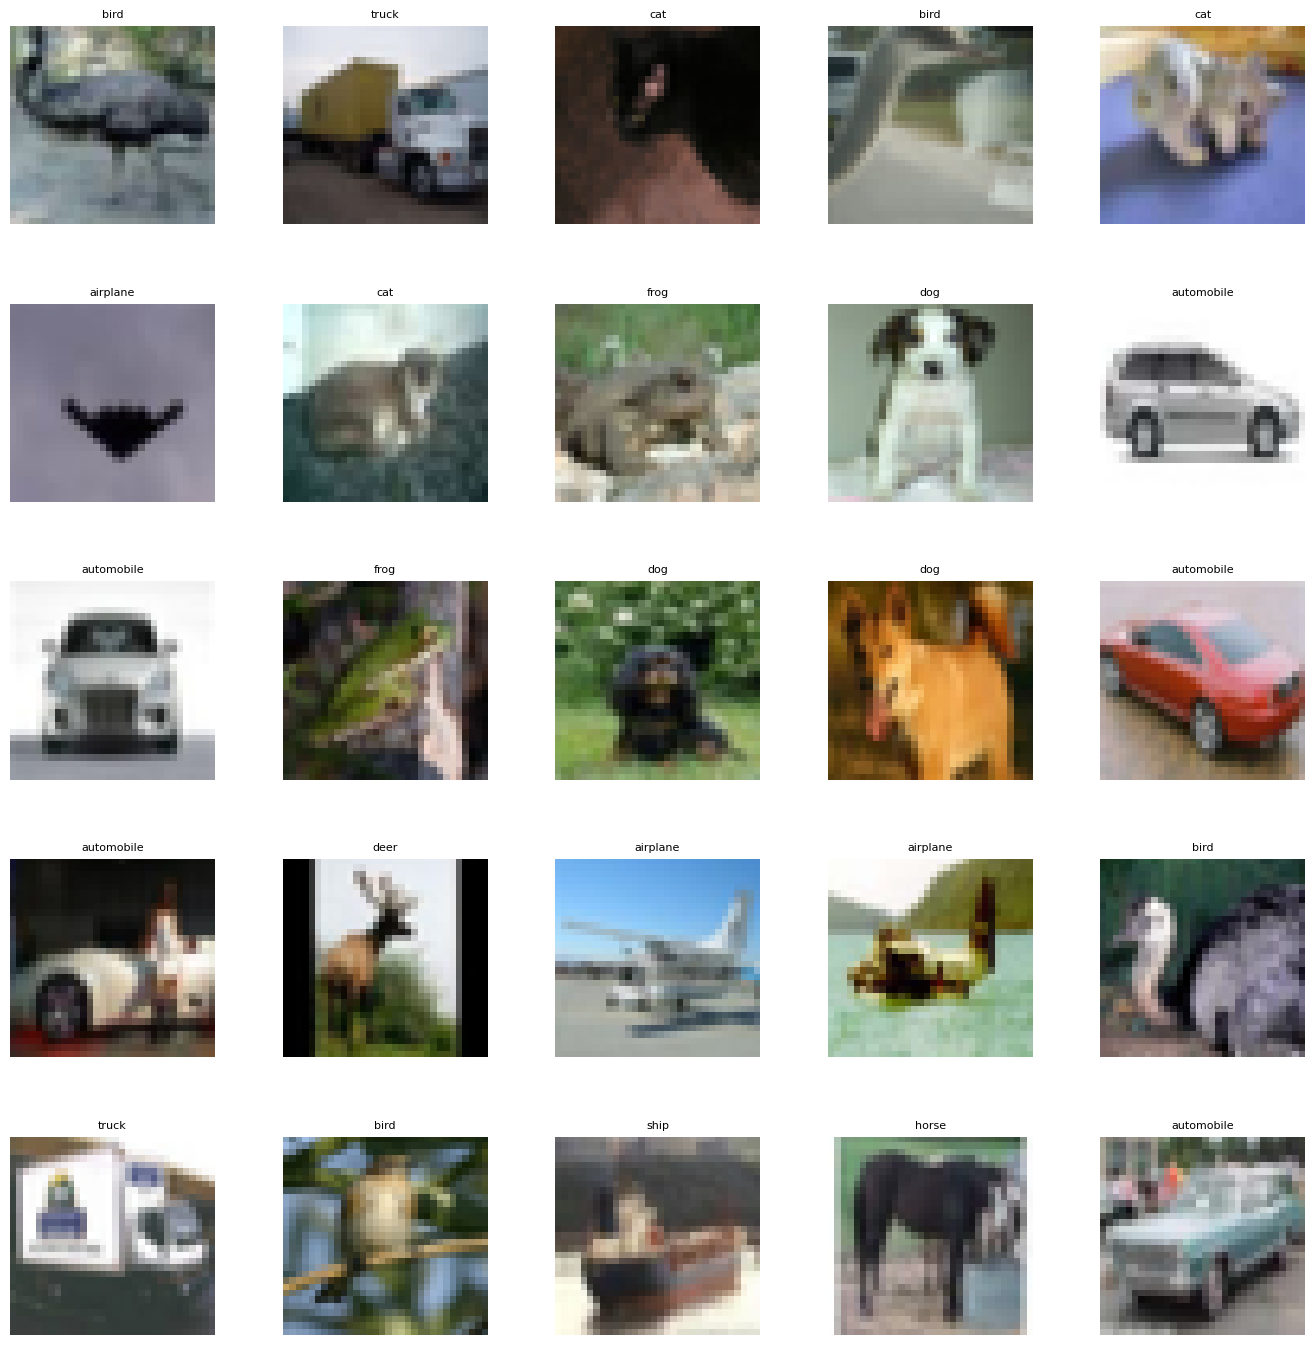

In [10]:
W_grid = 5
L_grid = 5
f, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel() 
n_train = len(x_train) 
for i in np.arange(0, W_grid * L_grid): 
    index = np.random.randint(0, n_train)

    axes[i].imshow(x_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(label_names[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)


Text(0.5, 1.0, 'Class distribution in training set')

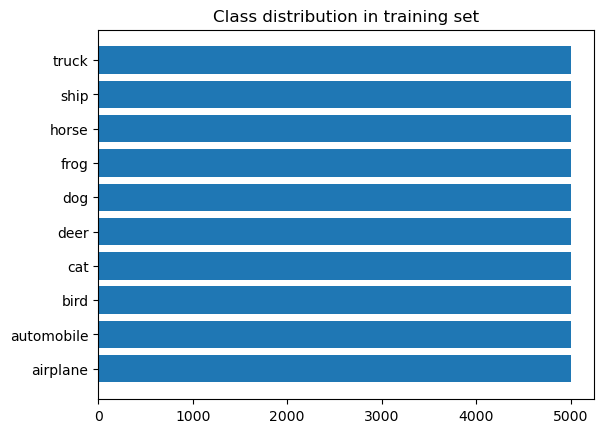

In [11]:
label_names
classes, counts = np.unique(y_train, return_counts=True)
plt.barh(label_names, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

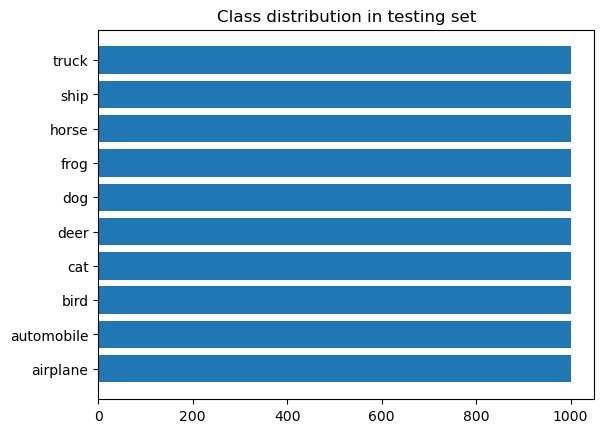

In [12]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(label_names, counts)
plt.title('Class distribution in testing set')

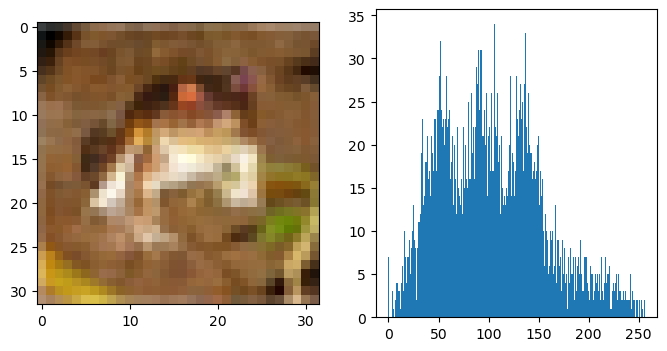

In [13]:
plt.show()
f,axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(x_train[0])
axes[1].hist(x_train[0].ravel(), 256, [0, 256])
plt.show()

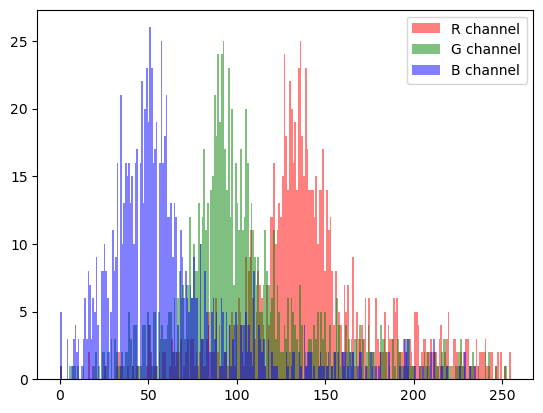

In [ ]:
colors = ['r', 'g', 'b']
for i, color in enumerate(colors):
    plt.hist(x_train[0][:, :, i].ravel(), bins=256, label=f'{color.upper()} channel')

plt.legend()
plt.show()


# normalize data

In [16]:
x_train[0][0]

array([[ 59,  62,  63],
       [ 43,  46,  45],
       [ 50,  48,  43],
       [ 68,  54,  42],
       [ 98,  73,  52],
       [119,  91,  63],
       [139, 107,  75],
       [145, 110,  80],
       [149, 117,  89],
       [149, 120,  93],
       [131, 103,  77],
       [125,  99,  76],
       [142, 115,  91],
       [144, 112,  86],
       [137, 105,  79],
       [129,  97,  71],
       [137, 106,  79],
       [134, 106,  76],
       [124,  97,  64],
       [139, 113,  78],
       [139, 112,  75],
       [133, 105,  69],
       [136, 105,  74],
       [139, 108,  77],
       [152, 120,  89],
       [163, 131, 100],
       [168, 136, 108],
       [159, 129, 102],
       [158, 130, 104],
       [158, 132, 108],
       [152, 125, 102],
       [148, 124, 103]], dtype=uint8)

In [ ]:
x_train = x_train.astype("float32") / 255.0 # Normalization for image to 1,0
x_test = x_test.astype("float32") / 255.0   # Normalization for image to 1,0


lb = LabelBinarizer()
y_cat_train = lb.fit_transform(y_train)  
y_cat_test = lb.transform(y_test)


In [174]:
y_cat_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

# Feature Extraction Functions

## Color Histogram Features
This function extracts color distribution features from images by:
1. Separating the RGB channels
2. Computing histograms for each channel
3. Normalizing the histograms by the total number of pixels

## HOG (Histogram of Oriented Gradients) Features
The HOG feature extraction:
1. Converts image to grayscale
2. Computes gradients using Sobel operators
3. Calculates magnitude and orientation
4. Creates histograms of gradient orientations for each cell

These features help capture both color and shape information from the images.

In [ ]:
def extract_color_histograms(images, bins=(8, 8, 8)):
    features = []
    for img in images:
        # we can use this cv2.split Instead of this
        r_channel = img[:, :, 0]
        g_channel = img[:, :, 1]
        b_channel = img[:, :, 2]
        
        channels = [r_channel ,g_channel ,b_channel ]
        
        hist_r = np.zeros(bins[0], dtype=np.float32)
        hist_g = np.zeros(bins[1], dtype=np.float32)
        hist_b = np.zeros(bins[2], dtype=np.float32)
        
        for channel, hist, bin_count in zip(channels, [hist_r, hist_g, hist_b], bins): 
            flattened = channel.flatten()
            bin_edges = np.linspace(0, 256, bin_count + 1)  # 0 32 64 96 128 160 192 224 255
            for pixel_value in flattened:
                for bin_index in range(bin_count):
                    if bin_edges[bin_index] <= pixel_value < bin_edges[bin_index + 1]:
                        hist[bin_index] += 1
                        break
        
        total_pixels = np.prod(img.shape[:2]) # 32*32
        hist_r /= total_pixels
        hist_g /= total_pixels
        hist_b /= total_pixels
        
        feature = np.concatenate([hist_r, hist_g, hist_b])
        features.append(feature)
    
    return np.array(features)

In [ ]:
def compute_hog(image, cell_size=(8, 8), bins=9):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    
    # Initialize gradient images
    gx = np.zeros_like(gray, dtype=np.float32)
    gy = np.zeros_like(gray, dtype=np.float32)
    
    # Sobel kernels
    sobel_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    sobel_y = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    
    # Compute gradients
    for i in range(1, h-1):
        for j in range(1, w-1):
            window = gray[i-1:i+2, j-1:j+2]
            gx[i,j] = np.sum(window * sobel_x)
            gy[i,j] = np.sum(window * sobel_y)
    
    # Compute magnitude and angle
    magnitude, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
    angle = angle % 180
    
    cell_h, cell_w = cell_size
    bins_range = 180 // bins  # 180/9 = 20 degrees per bin
    
    hog_vector = []
    
    # Compute HOG for each cell
    for i in range(0, h-cell_h+1, cell_h):
        for j in range(0, w-cell_w+1, cell_w):
            cell_mag = magnitude[i:i+cell_h, j:j+cell_w]
            cell_angle = angle[i:i+cell_h, j:j+cell_w]
            
            hist = np.zeros(bins, dtype=np.float32)
            
            for u in range(cell_mag.shape[0]):
                for v in range(cell_mag.shape[1]):
                    bin_idx = int(cell_angle[u, v] // bins_range) % bins
                    hist[bin_idx] += cell_mag[u, v]
            
            hog_vector.extend(hist)
    
    return np.array(hog_vector)

In [177]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        hog_feat = compute_hog(img)
        hog_features.append(hog_feat)
    return np.array(hog_features)

# Data Preprocessing and Feature Engineering

1. Convert images to uint8 format
2. Extract color histogram features
3. Extract HOG features
4. Combine both feature sets
5. Scale features using MinMaxScaler
6. Apply PCA for dimensionality reduction

In [153]:
x_train_uint8 = (x_train * 255).astype(np.uint8)
x_test_uint8 = (x_test * 255).astype(np.uint8)



In [ ]:

color_histograms_train = extract_color_histograms(x_train_uint8)
color_histograms_test = extract_color_histograms(x_test_uint8)

print(color_histograms_train )


[[0.13867188 0.5214844  0.18554688 ... 0.11425781 0.07519531 0.04589844]
 [0.03613281 0.10253906 0.18261719 ... 0.13574219 0.12792969 0.08300781]
 [0.01074219 0.1875     0.3359375  ... 0.02929688 0.03125    0.28515625]
 ...
 [0.14160156 0.15429688 0.19140625 ... 0.08398438 0.06640625 0.02636719]
 [0.02929688 0.03222656 0.05175781 ... 0.27246094 0.16210938 0.1328125 ]
 [0.04589844 0.1328125  0.13671875 ... 0.17773438 0.11914062 0.05957031]]


In [20]:
hog_train = extract_hog_features(x_train_uint8)
hog_test = extract_hog_features(x_test_uint8)

print(hog_train)

[[217.16896   200.14896   331.64905   ... 335.09604   211.7606
  220.09671  ]
 [539.99585   420.2422    478.1596    ... 299.70187   235.99112
  242.5811   ]
 [  4.          0.          8.485281  ...  21.937138   50.458366
   29.634336 ]
 ...
 [ 12.          0.          0.        ... 394.97513   333.65344
   67.37194  ]
 [ 13.          0.          1.4142135 ... 206.05807   280.76413
  496.63266  ]
 [259.63452   281.81247   200.42603   ... 128.49368   446.75986
   30.066593 ]]


In [ ]:

x_train_features = np.hstack((color_histograms_train, hog_train)) 
x_test_features = np.hstack((color_histograms_test, hog_test))

print(x_test_features)

[[1.17187500e-02 2.72460938e-01 1.57226562e-01 ... 9.09864502e+01
  1.39283886e+01 7.43468323e+01]
 [1.03515625e-01 6.64062500e-02 5.17578125e-02 ... 0.00000000e+00
  0.00000000e+00 9.38672180e+01]
 [1.17187500e-02 1.43554688e-01 1.05468750e-01 ... 1.71105957e+01
  0.00000000e+00 2.50184269e+01]
 ...
 [4.81445312e-01 1.88476562e-01 9.86328125e-02 ... 5.65685415e+00
  1.28362762e+02 2.97008453e+02]
 [8.88671875e-02 1.79687500e-01 3.61328125e-01 ... 3.21302490e+01
  5.81292458e+01 1.51381483e+01]
 [1.36718750e-02 2.07031250e-01 3.54492188e-01 ... 2.62648220e+01
  2.11679478e+01 3.36006287e+02]]


In [22]:
print("x_train_features shape:", x_train_features.shape)
print("x_test_features shape:", x_test_features.shape)

x_train_features shape: (50000, 168)
x_test_features shape: (10000, 168)


In [23]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_features)
x_test_scaled = scaler.transform(x_test_features)

In [24]:
pca = PCA(n_components=100, random_state=42) 
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

print("Reduced train shape:", x_train_pca.shape)
print("Reduced test shape:", x_test_pca.shape)

Reduced train shape: (50000, 100)
Reduced test shape: (10000, 100)


In [ ]:
models = {
    "KNN": {
        "estimator": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7, 9],
            "weights": ['uniform', 'distance'],
            "metric": ['euclidean', 'manhattan']
        }},
    
    "RandomForest": {
        "estimator": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [10, 20, None],
            "min_samples_split": [2, 5],
            "min_samples_leaf": [1, 2],
            "max_features": ['sqrt', 'log2']
        }},
    
    "SVM": {
        "estimator": SVC(),
        "params": {
            "C": [1, 10, 100],
            "gamma": [0.001, 0.01, 0.1],
            "kernel": ['rbf']
        }}
}


# Model Training and Evaluation


1. K-Nearest Neighbors (KNN)
2. Random Forest
3. Support Vector Machine (SVM)

For each model:
- Use GridSearchCV for hyperparameter tuning
- Evaluate performance using classification reports
- Compare accuracies to find the best model

In [26]:
best_models = {}  

for name, config in models.items():
    print(f"\n--- Training {name} ---")
    
    grid = GridSearchCV(config["estimator"], config["params"],
                        cv=2, n_jobs=-1, verbose=1)
    grid.fit(x_train_pca, y_train)

    print(f"Best parameters for {name}: {grid.best_params_}")

    y_pred = grid.predict(x_test_pca)

    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test, y_pred, target_names=label_names))

    # calc accuracy
    acc = grid.score(x_test_pca, y_test)
    print(f"Accuracy for {name}: {acc:.4f}")

    # store the best model
    best_models[name] = {
        'model': grid.best_estimator_,
        'accuracy': acc,
        'best_params': grid.best_params_
    }

best_model_name = max(best_models, key=lambda x: best_models[x]['accuracy'])
print(f"\n✅ Best overall model: {best_model_name}")
print(f"   Accuracy: {best_models[best_model_name]['accuracy']:.4f}")
print(f"   Parameters: {best_models[best_model_name]['best_params']}")



--- Training KNN ---
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}

Classification Report for KNN:

              precision    recall  f1-score   support

    airplane       0.72      0.48      0.57      1000
  automobile       0.70      0.63      0.66      1000
        bird       0.48      0.25      0.33      1000
         cat       0.38      0.25      0.30      1000
        deer       0.34      0.60      0.43      1000
         dog       0.46      0.40      0.43      1000
        frog       0.45      0.74      0.56      1000
       horse       0.73      0.45      0.55      1000
        ship       0.54      0.73      0.62      1000
       truck       0.61      0.61      0.61      1000

    accuracy                           0.51     10000
   macro avg       0.54      0.51      0.51     10000
weighted avg       0.54      0.51      0.51     10000

Accuracy for KNN: 0.5136

--- Trainin

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Label axes
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate tick labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                   ha="center", va="center",
                   color="white" if cm[i, j] > thresh else "black")
    
    fig.tight_layout()
    return ax

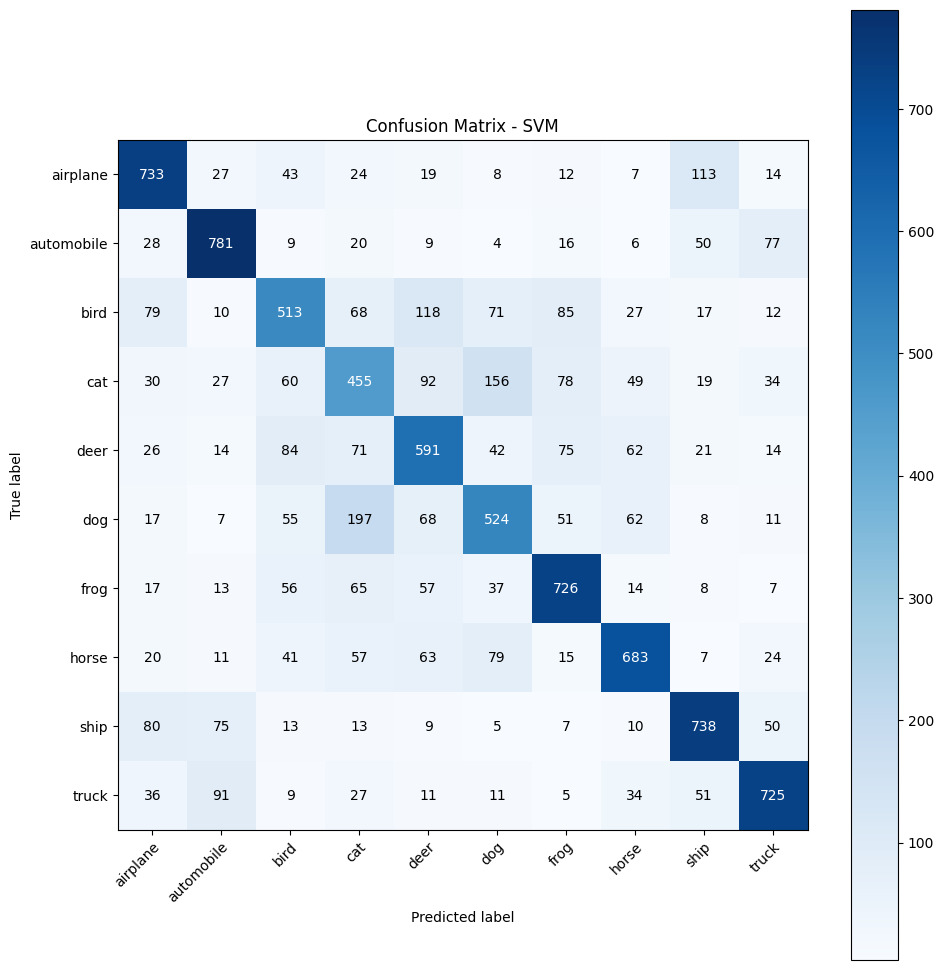

In [28]:
best_model = best_models[best_model_name]['model']
y_pred_best = best_model.predict(x_test_pca)
plot_confusion_matrix(y_test, y_pred_best, label_names, 
                     f'Confusion Matrix - {best_model_name}')
plt.show()

# Image Transformation Analysis

## Gaussian Blur Analysis

1. Applying different levels of Gaussian blur (3x3, 5x5, 7x7 kernels)
2. Extracting features from blurred images
3. Evaluating model performance on blurred data
4. Visualizing the effects of different blur levels


In [ ]:
def apply_manual_blur(images, kernel_size=5):
    """Apply manual blur to a batch of images using convolution with border handling"""
    # Create averaging kernel
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)
    
    blurred_images = np.zeros_like(images)
    pad = kernel_size // 2
    
    for idx, img in enumerate(images):
        # Process each channel separately
        for channel in range(3):
            img_channel = img[:,:,channel]
            h, w = img_channel.shape
            new_channel = np.zeros((h, w), np.float32)
            
            # Create padded image with duplicated borders
            padded = np.pad(img_channel, pad, mode='edge') #mode='edge' means repeating the border pixel values
            
            # Manual convolution including borders
            for i in range(h):
                for j in range(w):
                    # Extract window from padded image
                    window = padded[i:i+kernel_size, j:j+kernel_size]
                    sop = np.sum(window * kernel)
                    new_channel[i,j] = np.clip(sop, 0, 1)
            
            blurred_images[idx,:,:,channel] = new_channel
    
    return blurred_images

Using SVM model for manual blur analysis

Testing with manual blur kernel size 3x3

Classification Report for Manual Blur Kernel 3x3:

              precision    recall  f1-score   support

    airplane       0.62      0.62      0.62      1000
  automobile       0.76      0.53      0.62      1000
        bird       0.46      0.50      0.48      1000
         cat       0.35      0.51      0.42      1000
        deer       0.41      0.62      0.49      1000
         dog       0.52      0.43      0.47      1000
        frog       0.68      0.38      0.48      1000
       horse       0.76      0.47      0.58      1000
        ship       0.51      0.82      0.63      1000
       truck       0.76      0.46      0.57      1000

    accuracy                           0.53     10000
   macro avg       0.58      0.53      0.54     10000
weighted avg       0.58      0.53      0.54     10000



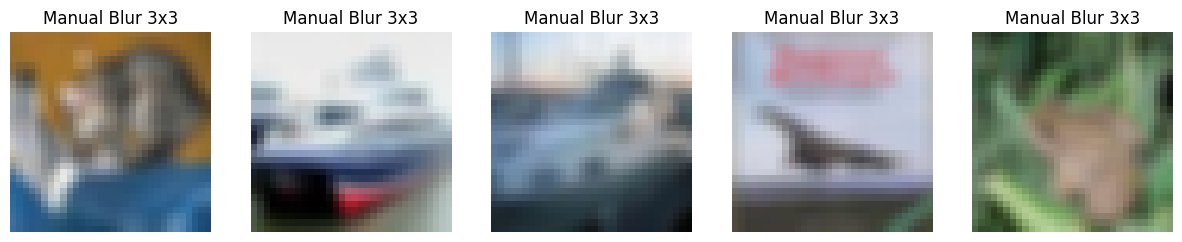


Testing with manual blur kernel size 5x5

Classification Report for Manual Blur Kernel 5x5:

              precision    recall  f1-score   support

    airplane       0.52      0.51      0.51      1000
  automobile       0.75      0.20      0.32      1000
        bird       0.36      0.45      0.40      1000
         cat       0.26      0.49      0.34      1000
        deer       0.31      0.58      0.41      1000
         dog       0.44      0.34      0.38      1000
        frog       0.60      0.19      0.28      1000
       horse       0.76      0.23      0.35      1000
        ship       0.37      0.82      0.51      1000
       truck       0.69      0.13      0.21      1000

    accuracy                           0.39     10000
   macro avg       0.51      0.39      0.37     10000
weighted avg       0.51      0.39      0.37     10000



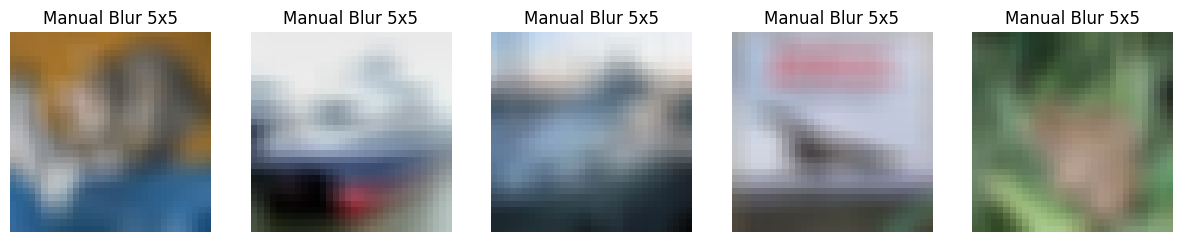


Testing with manual blur kernel size 7x7

Classification Report for Manual Blur Kernel 7x7:

              precision    recall  f1-score   support

    airplane       0.46      0.41      0.43      1000
  automobile       0.70      0.09      0.15      1000
        bird       0.29      0.41      0.34      1000
         cat       0.23      0.46      0.31      1000
        deer       0.27      0.57      0.37      1000
         dog       0.37      0.26      0.30      1000
        frog       0.49      0.10      0.16      1000
       horse       0.74      0.10      0.17      1000
        ship       0.33      0.80      0.47      1000
       truck       0.69      0.04      0.07      1000

    accuracy                           0.32     10000
   macro avg       0.46      0.32      0.28     10000
weighted avg       0.46      0.32      0.28     10000



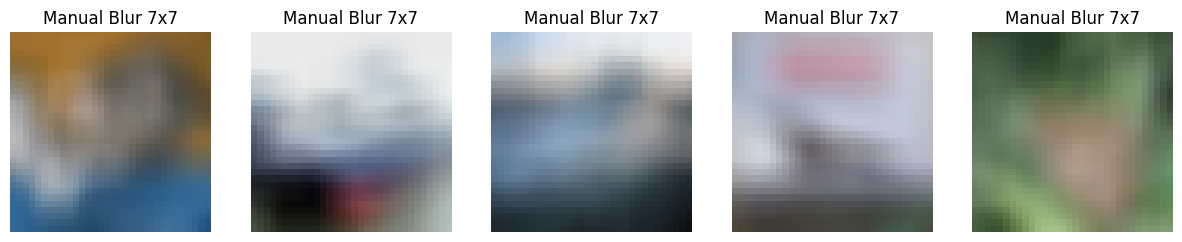

In [ ]:

# blur analysis section
best_model = best_models[best_model_name]['model']
print(f"Using {best_model_name} model for manual blur analysis")

# Create blurred versions of the test set
blur_kernels = [3, 5, 7]  
blurred_results = {}

for kernel_size in blur_kernels:
    print(f"\nTesting with manual blur kernel size {kernel_size}x{kernel_size}")
    
    # Apply manual blur to test images
    x_test_blurred = apply_manual_blur(x_test, kernel_size)
    
    # Extract features from blurred images
    x_test_blurred_uint8 = (x_test_blurred * 255).astype(np.uint8)
    
    # Extract color histograms
    color_histograms_blurred = extract_color_histograms(x_test_blurred_uint8)
    
    # Extract HOG features
    hog_features_blurred = extract_hog_features(x_test_blurred_uint8)
    
    # Combine features
    x_test_blurred_features = np.hstack((color_histograms_blurred, hog_features_blurred))
    
    # Apply scaling and PCA
    x_test_blurred_scaled = scaler.transform(x_test_blurred_features)
    x_test_blurred_pca = pca.transform(x_test_blurred_scaled)
    
    # Test model on blurred data
    y_pred_blurred = best_model.predict(x_test_blurred_pca)
    blurred_acc = (y_pred_blurred == y_test).mean()
    
    print(f"\nClassification Report for Manual Blur Kernel {kernel_size}x{kernel_size}:\n")
    print(classification_report(y_test, y_pred_blurred, target_names=label_names))
    
    # Save results
    blurred_results[kernel_size] = {
        'accuracy': blurred_acc,
        'predictions': y_pred_blurred
    }
    
    # Display sample blurred images
    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(x_test_blurred[i])
        plt.title(f'Manual Blur {kernel_size}x{kernel_size}')
        plt.axis('off')
    plt.show()

# laplacib Analysis


In [ ]:
def apply_manual_laplacian(images, sharpen=False, alpha=0.5):
    # Define Laplacian kernel
    kernel = np.array([
        [0, 1, 0],
        [1, -4, 1],
        [0, 1, 0]
    ])
    
    laplacian_images = np.zeros_like(images, dtype=np.float32)
    
    for idx, img in enumerate(images):
        # Convert to grayscale
        gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_BGR2GRAY)
        h, w = gray.shape
        new_image = np.zeros((h, w), dtype=np.float32)
        
        # Manual convolution
        for i in range(1, h-1):
            for j in range(1, w-1):
                window = gray[i-1:i+2, j-1:j+2]
                sop = np.sum(window * kernel)
                new_image[i,j] = sop
                
        # Normalize to [0,1] range
        if new_image.max() - new_image.min() > 0:
            new_image = (new_image - new_image.min()) / (new_image.max() - new_image.min())
        
        if sharpen:
            # For sharpening, we add the edge detection result back to the original grayscale
            sharpened = gray.astype(np.float32) / 255.0 + alpha * new_image
            # Normalize sharpened image
            sharpened = np.clip(sharpened, 0, 1)
            # Use the sharpened result
            new_image = sharpened
        
        # Convert to RGB by stacking
        laplacian_rgb = np.stack([new_image]*3, axis=-1)
        laplacian_images[idx] = laplacian_rgb
    
    return laplacian_images



Classification Report for Laplacian Edge Detection:

              precision    recall  f1-score   support

    airplane       0.31      0.80      0.45      1000
  automobile       0.62      0.39      0.48      1000
        bird       0.31      0.44      0.36      1000
         cat       0.32      0.10      0.15      1000
        deer       0.34      0.13      0.19      1000
         dog       0.33      0.23      0.27      1000
        frog       0.23      0.79      0.36      1000
       horse       0.73      0.15      0.25      1000
        ship       0.85      0.11      0.20      1000
       truck       0.74      0.17      0.28      1000

    accuracy                           0.33     10000
   macro avg       0.48      0.33      0.30     10000
weighted avg       0.48      0.33      0.30     10000


Classification Report for Laplacian Sharpening:

              precision    recall  f1-score   support

    airplane       0.30      0.70      0.42      1000
  automobile       0.83     

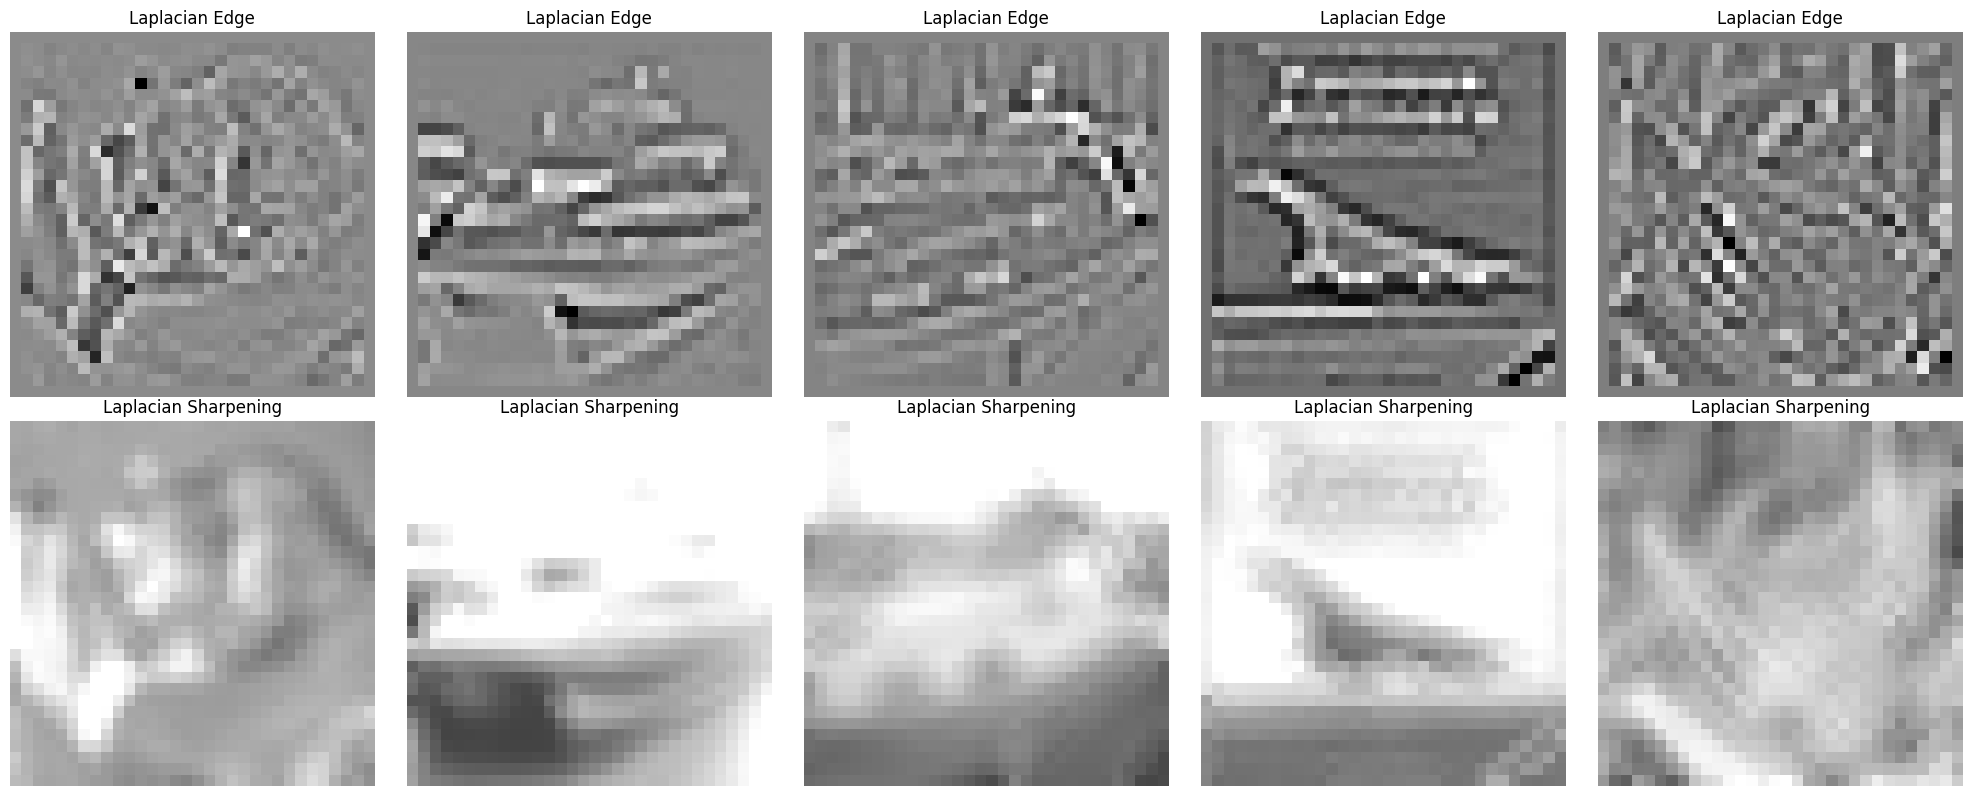

In [ ]:
# 1. Apply Laplacian edge detection
x_test_edge = apply_manual_laplacian(x_test, sharpen=False)

# 2. Apply Laplacian sharpening
x_test_sharp = apply_manual_laplacian(x_test, sharpen=True, alpha=0.5)

# Extract features for edge detection
x_test_edge_uint8 = (x_test_edge * 255).astype(np.uint8)
color_hist_edge = extract_color_histograms(x_test_edge_uint8)
hog_edge = extract_hog_features(x_test_edge_uint8)
x_test_edge_features = np.hstack((color_hist_edge, hog_edge))

# Extract features for sharpened images
x_test_sharp_uint8 = (x_test_sharp * 255).astype(np.uint8)
color_hist_sharp = extract_color_histograms(x_test_sharp_uint8)
hog_sharp = extract_hog_features(x_test_sharp_uint8)
x_test_sharp_features = np.hstack((color_hist_sharp, hog_sharp))

# Apply scaling and PCA
x_test_edge_scaled = scaler.transform(x_test_edge_features)
x_test_edge_pca = pca.transform(x_test_edge_scaled)

x_test_sharp_scaled = scaler.transform(x_test_sharp_features)
x_test_sharp_pca = pca.transform(x_test_sharp_scaled)

# Get predictions
y_pred_edge = best_model.predict(x_test_edge_pca)
y_pred_sharp = best_model.predict(x_test_sharp_pca)

edge_acc = (y_pred_edge == y_test).mean()
sharp_acc = (y_pred_sharp == y_test).mean()

# Print results
print("\nClassification Report for Laplacian Edge Detection:\n")
print(classification_report(y_test, y_pred_edge, target_names=label_names))

print("\nClassification Report for Laplacian Sharpening:\n")
print(classification_report(y_test, y_pred_sharp, target_names=label_names))

# Display examples
fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 8))

# Show edge detection results
for i in range(5):
    ax1[i].imshow(x_test_edge[i])
    ax1[i].set_title('Laplacian Edge')
    ax1[i].axis('off')

# Show sharpening results
for i in range(5):
    ax2[i].imshow(x_test_sharp[i])
    ax2[i].set_title('Laplacian Sharpening')
    ax2[i].axis('off')

plt.tight_layout()
plt.show()

# Results Comparison and Analysis
 compare the model's performance across different image transformations:

1. Base Performance:
   - Original image accuracy (baseline)

2. Blur Analysis:
   - Performance with different Gaussian blur kernels (3x3, 5x5, 7x7)
   - Impact of increasing blur on accuracy

3. Edge Detection:
   - Performance with Sobel edge detection
   - Comparison with baseline accuracy

The visualization includes:
- Bar chart comparing accuracies across transformations
- Numerical accuracy values and differences (Δ) from baseline
- Statistical significance of performance changes

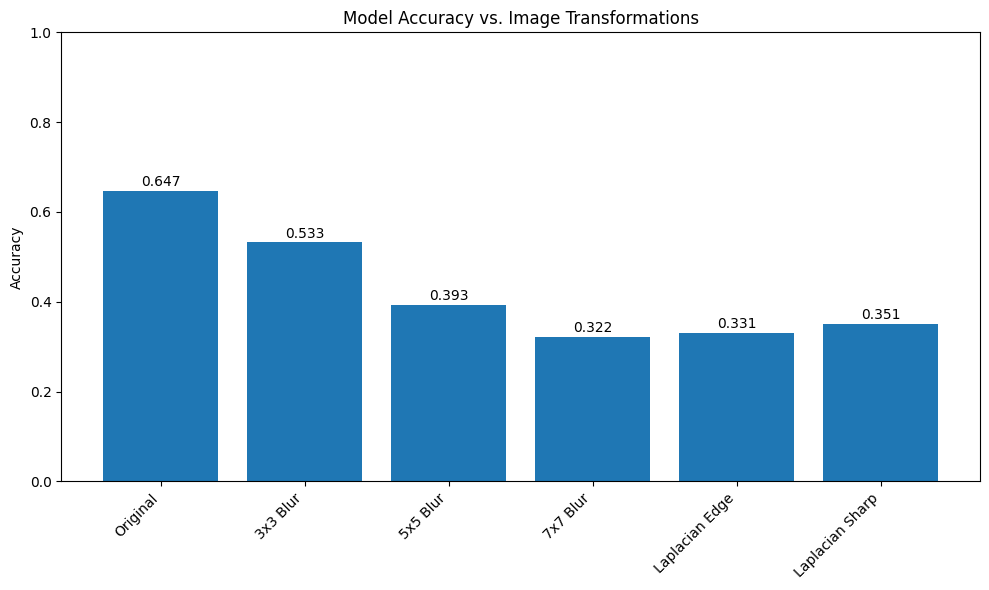


Accuracy Comparison:
Original: 0.647
Kernel 3x3: 0.533 (Δ: -0.114)
Kernel 5x5: 0.393 (Δ: -0.254)
Kernel 7x7: 0.322 (Δ: -0.325)
Laplacian Edge: 0.331 (Δ: -0.316)
Laplacian Sharp: 0.351 (Δ: -0.296)


In [33]:
# Compare accuracies including edge detection and sharpening
plt.figure(figsize=(10, 6))

# Make sure we have all results before creating comparison
if len(blurred_results) == len(blur_kernels):
    accuracies = [best_models[best_model_name]['accuracy']]
    labels = ['Original']
    
    # Add results for each blur level
    for k in blur_kernels:
        if k in blurred_results:
            accuracies.append(blurred_results[k]['accuracy'])
            labels.append(f'{k}x{k} Blur')
    
    # Add edge detection and sharpening results
    accuracies.extend([edge_acc, sharp_acc])
    labels.extend(['Laplacian Edge', 'Laplacian Sharp'])
    
    plt.bar(labels, accuracies)
    plt.title('Model Accuracy vs. Image Transformations')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    # Add value labels on top of each bar
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Print detailed comparison
    print('\nAccuracy Comparison:')
    print(f'Original: {accuracies[0]:.3f}')
    
    # Print blur results
    for i, (kernel, acc) in enumerate(zip(blur_kernels, accuracies[1:len(blur_kernels)+1]), 1):
        print(f'Kernel {kernel}x{kernel}: {acc:.3f} (Δ: {acc - accuracies[0]:.3f})')
    
    # Print edge detection and sharpening results
    print(f'Laplacian Edge: {edge_acc:.3f} (Δ: {edge_acc - accuracies[0]:.3f})')
    print(f'Laplacian Sharp: {sharp_acc:.3f} (Δ: {sharp_acc - accuracies[0]:.3f})')
else:
    print('Please run the blur analysis first to generate all results')

# Save Model and Preprocessing Components

We'll save:
1. The best trained model
2. The MinMaxScaler used for feature scaling
3. The PCA transformer
4. Model configuration details


In [ ]:
# Create a directory for saving models if it doesn't exist
save_dir = 'saved_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the best model
model_path = os.path.join(save_dir, f'best_model_{best_model_name}.joblib')
joblib.dump(best_models[best_model_name]['model'], model_path)
print(f"Saved best model to: {model_path}")

# Save the scaler
scaler_path = os.path.join(save_dir, 'feature_scaler.joblib')
joblib.dump(scaler, scaler_path)
print(f"Saved feature scaler to: {scaler_path}")

# Save the PCA transformer
pca_path = os.path.join(save_dir, 'pca_transformer.joblib')
joblib.dump(pca, pca_path)
print(f"Saved PCA transformer to: {pca_path}")

# Save model configuration and performance metrics
config = {
    'model_name': best_model_name,
    'accuracy': best_models[best_model_name]['accuracy'],
    'best_parameters': best_models[best_model_name]['best_params'],
    'feature_info': {
        'color_histogram_bins': (8, 8, 8),
        'pca_components': pca.n_components_
    },
    'class_labels': label_names
}

config_path = os.path.join(save_dir, 'model_config.joblib')
joblib.dump(config, config_path)
print(f"Saved model configuration to: {config_path}")

Saved best model to: saved_models/best_model_SVM.joblib
Saved feature scaler to: saved_models/feature_scaler.joblib
Saved PCA transformer to: saved_models/pca_transformer.joblib
Saved model configuration to: saved_models/model_config.joblib


# Testing Model Predictions


1. Select random images from the test set
2. Make predictions using our best model
3. Display the images with their predicted and actual labels
4. Show prediction confidence scores

In [155]:
def load_model_components(model_dir):
    # Load the model
    model = joblib.load(os.path.join(model_dir, f'best_model_{joblib.load(os.path.join(model_dir, "model_config.joblib"))["model_name"]}.joblib'))
    
    # Load the scaler
    scaler = joblib.load(os.path.join(model_dir, 'feature_scaler.joblib'))
    
    # Load the PCA transformer
    pca = joblib.load(os.path.join(model_dir, 'pca_transformer.joblib'))
    
    # Load the configuration
    config = joblib.load(os.path.join(model_dir, 'model_config.joblib'))
    
    return model, scaler, pca, config



Making predictions using saved model...



d:\New folder\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.2.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\New folder\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.2.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\New folder\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.2.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more 

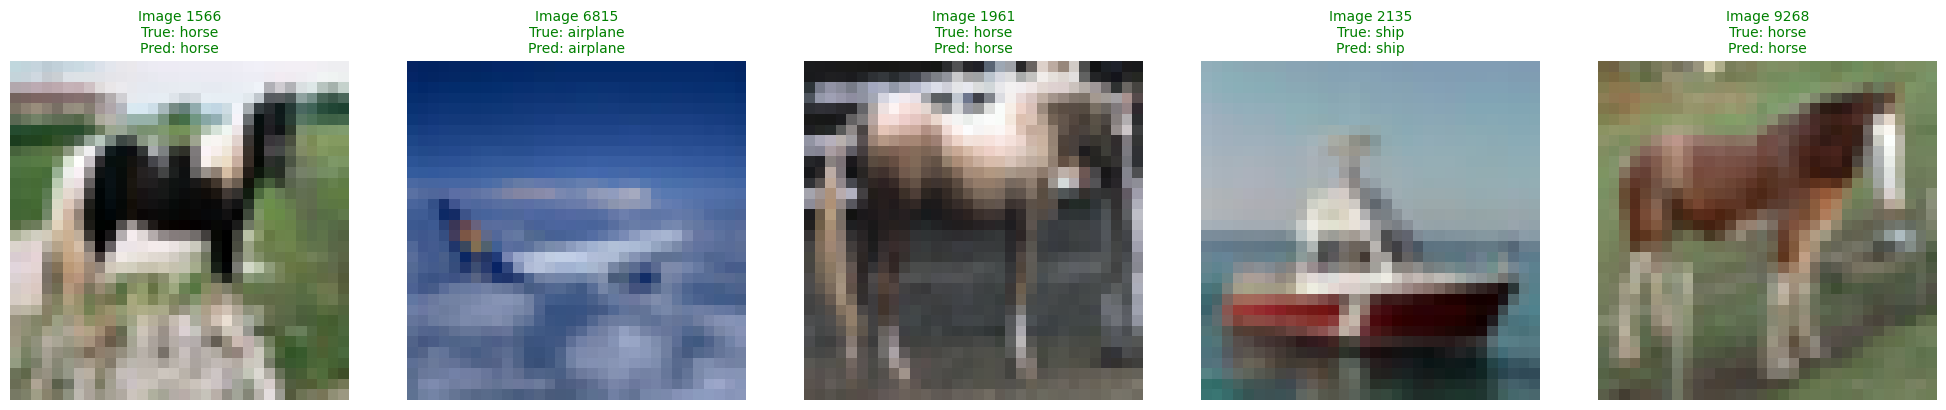


Model: SVM
Accuracy: 0.6469
Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Total number of test images available: 10000
You can specify any indices between 0 and 9999


In [192]:
def show_predictions_from_saved_model(indices=None, num_images=10, model_dir='saved_models'):
    # Load saved model components
    model, scaler, pca, config = load_model_components(model_dir)
    label_names = config['class_labels']
    
    if indices is None:
        indices = list(range(num_images))
    else:
        num_images = len(indices)
    
    # Get features for these images
    test_images = x_test[indices]
    test_images_uint8 = (test_images * 255).astype(np.uint8)
    
    # Extract features
    color_hist = extract_color_histograms(test_images_uint8)
    hog_feat = extract_hog_features(test_images_uint8)
    
    # Combine features
    features = np.hstack((color_hist, hog_feat))
    
    # Scale and apply PCA
    features_scaled = scaler.transform(features)
    features_pca = pca.transform(features_scaled)
    
    # Get predictions
    predictions = model.predict(features_pca)
    
    # Calculate rows and columns for subplot grid
    n_rows = (num_images - 1) // 5 + 1
    n_cols = min(5, num_images)
    
    # Create a figure
    fig = plt.figure(figsize=(n_cols * 4, n_rows * 4))
    
    for idx, i in enumerate(range(num_images)):
        # Add subplot
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        
        # Show image
        plt.imshow(test_images[i])
        
        # Get true and predicted labels
        true_label = label_names[y_test[indices[i]]]
        pred_label = label_names[predictions[i]]
        
        # Set title color based on prediction correctness
        title_color = 'green' if true_label == pred_label else 'red'
        
        # Set title with true and predicted labels
        plt.title(f'Image {indices[i]}\nTrue: {true_label}\nPred: {pred_label}', 
                  color=title_color, 
                  fontsize=10)
        
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print model information
    print(f"\nModel: {config['model_name']}")
    print(f"Accuracy: {config['accuracy']:.4f}")
    print(f"Parameters: {config['best_parameters']}")

# Example usage
print("Making predictions using saved model...\n")
show_predictions_from_saved_model(indices=[1566, 6815, 1961, 2135, 9268])

print(f"\nTotal number of test images available: {len(x_test)}")
print("You can specify any indices between 0 and", len(x_test)-1)

# CNN

In [37]:
# Import required libraries for CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical format for CNN
y_train_cnn = to_categorical(y_train)
y_test_cnn = to_categorical(y_test)

# Define CNN model
def create_cnn_model(input_shape=(32, 32, 3), num_classes=10):
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Dense layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create and compile model
cnn_model = create_cnn_model()
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Print model summary
cnn_model.summary()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
print("\nTraining CNN model...")
history = cnn_model.fit(x_train, y_train_cnn,
                       batch_size=64,
                       epochs=20,
                       validation_split=0.2,
                       callbacks=[early_stopping],
                       verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747344839.005529      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747344839.006414      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,345,066 (5.13 MB)

 Trainable params: 1,343,146 (5.12 MB)

 Non-trainable params: 1,920 (7.50 KB)


Training CNN model...
Epoch 1/20


I0000 00:00:1747344849.361230     122 service.cc:148] XLA service 0x7f25d8017330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747344849.362126     122 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747344849.362146     122 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747344850.163553     122 cuda_dnn.cc:529] Loaded cuDNN version 90300


 15/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.1243 - loss: 3.4838  

I0000 00:00:1747344857.403742     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.3463 - loss: 2.1143 - val_accuracy: 0.4099 - val_loss: 1.7166
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5934 - loss: 1.1374 - val_accuracy: 0.6259 - val_loss: 1.0658
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6747 - loss: 0.9157 - val_accuracy: 0.6932 - val_loss: 0.9121
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7267 - loss: 0.7839 - val_accuracy: 0.7189 - val_loss: 0.8104
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7525 - loss: 0.7059 - val_accuracy: 0.7537 - val_loss: 0.7115
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7824 - loss: 0.6307 - val_accuracy: 0.7692 - val_loss: 0.6610
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7939 - loss: 0.5880 - val_accuracy: 0.7730 - val_loss: 0.6543
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8079 - loss: 0.5521 - val_accuracy: 0.8042 - va


CNN Test accuracy: 0.8277
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Classification Report for CNN:
              precision    recall  f1-score   support

    airplane       0.84      0.86      0.85      1000
  automobile       0.88      0.94      0.91      1000
        bird       0.79      0.74      0.76      1000
         cat       0.68      0.68      0.68      1000
        deer       0.77      0.86      0.82      1000
         dog       0.78      0.69      0.73      1000
        frog       0.80      0.90      0.85      1000
       horse       0.91      0.84      0.87      1000
        ship       0.93      0.89      0.91      1000
       truck       0.91      0.86      0.89      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



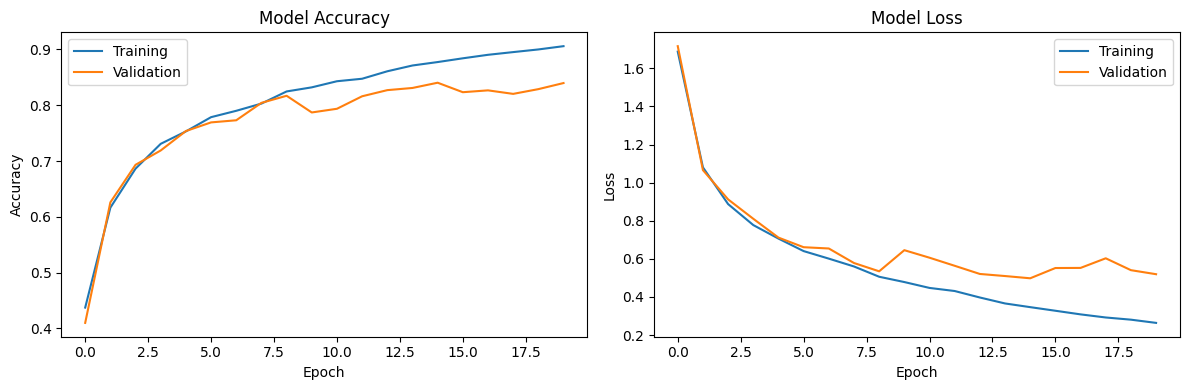

In [38]:
# Evaluate CNN model
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(x_test, y_test_cnn, verbose=0)
print(f"\nCNN Test accuracy: {cnn_test_acc:.4f}")

# Get CNN predictions
y_pred_cnn = cnn_model.predict(x_test)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

# Print classification report
print("\nClassification Report for CNN:")
print(classification_report(y_test, y_pred_cnn_classes, target_names=label_names))

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save CNN Model and try it 


In [39]:
cnn_save_dir = 'saved_cnn_model'
if not os.path.exists(cnn_save_dir):
    os.makedirs(cnn_save_dir)

# Save the CNN model
model_path = os.path.join(cnn_save_dir, 'cifar10_cnn_model.h5')
cnn_model.save(model_path)
print(f"Saved CNN model to: {model_path}")

# Save training history
history_path = os.path.join(cnn_save_dir, 'training_history.joblib')
joblib.dump(history.history, history_path)
print(f"Saved training history to: {history_path}")

# Save model configuration and performance metrics
cnn_config = {
    'input_shape': (32, 32, 3),
    'num_classes': 10,
    'test_accuracy': cnn_test_acc,
    'class_labels': label_names,
    'early_stopping_patience': 5,
    'batch_size': 64,
    'initial_learning_rate': 0.001
}

config_path = os.path.join(cnn_save_dir, 'cnn_config.joblib')
joblib.dump(cnn_config, config_path)
print(f"Saved CNN configuration to: {config_path}")

Saved CNN model to: saved_cnn_model/cifar10_cnn_model.h5
Saved training history to: saved_cnn_model/training_history.joblib
Saved CNN configuration to: saved_cnn_model/cnn_config.joblib


Loading saved CNN model...

Testing loaded model on sample images...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


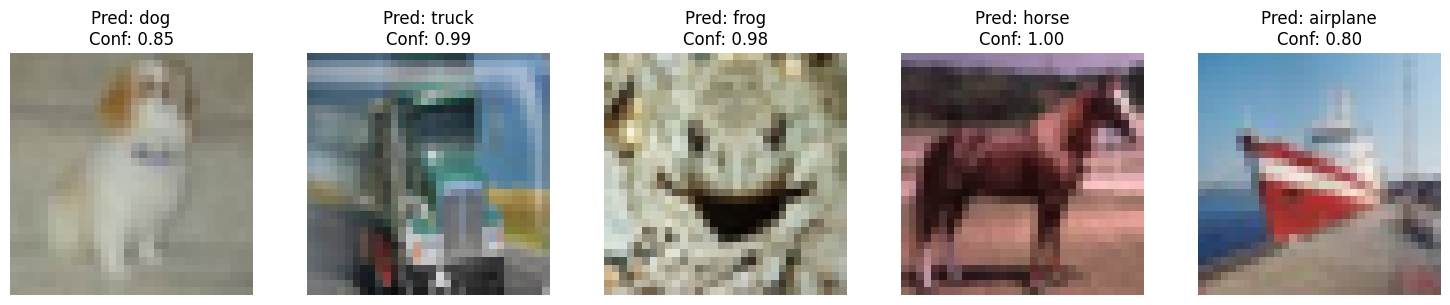


Loaded model test accuracy: 0.8277

Model configuration:
input_shape: (32, 32, 3)
num_classes: 10
test_accuracy: 0.8277000188827515
early_stopping_patience: 5
batch_size: 64
initial_learning_rate: 0.001


In [74]:
from tensorflow.keras.models import load_model

def load_cnn_model(model_dir='saved_cnn_model'):
    """Load saved CNN model and its components."""
    # Load model
    model = load_model(os.path.join(model_dir, 'cifar10_cnn_model.h5'))
    
    # Load configuration
    config = joblib.load(os.path.join(model_dir, 'cnn_config.joblib'))
    
    # Load training history
    history = joblib.load(os.path.join(model_dir, 'training_history.joblib'))
    
    return model, config, history

def predict_image(model, image, config):
    """Make prediction for a single image."""
    # Ensure image is in the right format
    if image.shape != (32, 32, 3):
        raise ValueError("Image must be 32x32x3")
    
    # Add batch dimension
    image_batch = np.expand_dims(image, 0)
    
    # Get prediction
    prediction = model.predict(image_batch)[0]
    predicted_class = np.argmax(prediction)
    confidence = prediction[predicted_class]
    
    return {
        'class_name': config['class_labels'][predicted_class],
        'confidence': confidence,
        'probabilities': dict(zip(config['class_labels'], prediction))
    }

# Load the saved model and test it
print("Loading saved CNN model...")
loaded_model, loaded_config, loaded_history = load_cnn_model()

# Test the loaded model on a few images
print("\nTesting loaded model on sample images...")
test_indices = np.random.randint(0, len(x_test), 5)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(test_indices):
    # Get the test image
    test_image = x_test[idx]
    
    # Make prediction
    result = predict_image(loaded_model, test_image, loaded_config)
    
    # Plot image with prediction
    plt.subplot(1, 5, i + 1)
    plt.imshow(test_image)
    plt.title(f"Pred: {result['class_name']}\nConf: {result['confidence']:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print model performance
print(f"\nLoaded model test accuracy: {loaded_config['test_accuracy']:.4f}")
print("\nModel configuration:")
for key, value in loaded_config.items():
    if key != 'class_labels':  # Skip printing the class labels
        print(f"{key}: {value}")